In [19]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier


Load the data in dataframes.

Homogenize the title with some other categories

In [26]:
DATA_PATH = "./data/"

df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


Homogenize the title with some other categories:


*   Officer
*   Royalty
- Mr, Mrs, Ms



In [27]:



get_Title_from_Name = None

get_Title_from_Name = lambda name: name.split(',')[1].split('.')[0].strip()

df['Title']      = df['Name'].map(get_Title_from_Name)
df_test['Title'] = df_test['Name'].map(get_Title_from_Name)

title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Officer",
    "Lady" : "Royalty"
}


df['Title']      = df.Title.map(title_dictionary)
df_test['Title'] = df_test.Title.map(title_dictionary)



## Check if the port of boarding can be used and has a balanced entry.

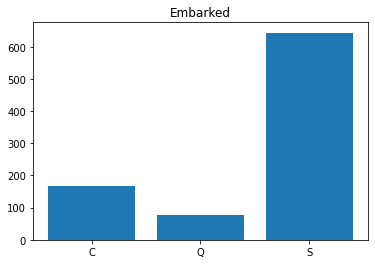

In [28]:
a = df.groupby(['Embarked']).size()


plt.bar(*zip(*a.items()))
plt.title('Embarked')
plt.show()


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
dtype: int64

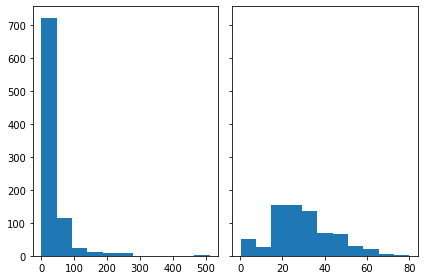

In [29]:
df.describe()


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# Bin boxes
axs[0].hist(df.Fare, bins=11)
axs[1].hist(df.Age, bins=11)

df.isna().sum()



## Fill the missing values in age and in embarked

Use mean for the age and mode for the starting port

In [30]:


df['Age'].fillna(value=df['Age'].mean(), inplace=True)
df["Embarked"].fillna(value=df['Embarked'].mode()[0], inplace=True)


df.isna().sum()
#df['Embarked'].mode()[0]


Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
Title         0
dtype: int64

In [31]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes


x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin'])


cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']


## Define the pipeline for the numeric columns and the categorical ones

In [33]:

num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')) 
    ] )

cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1))
    ] )

tree_prepro = compose.ColumnTransformer(transformers=[
     ('num', num_4_treeModels, num_vars),
     ('cat', cat_4_treeModels, cat_vars),
 ], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Trees":   ExtraTreesClassifier(n_estimators=100),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "AdaBoost":      AdaBoostClassifier(n_estimators=100),
    "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
    "Skl HistGBM":   HistGradientBoostingClassifier(max_iter=100),
    "XGBoost":       XGBClassifier(n_estimators=100, use_label_encoder=False), 
    "LightGBM":      LGBMClassifier(n_estimators=100),
    "CatBoost":      CatBoostClassifier(n_estimators=100, verbose = False),
}


tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

tree_classifiers["LightGBM"]


x_train, x_val, y_train, y_val = model_selection.train_test_split( x, y, test_size=0.2, stratify = y, random_state=4 )


results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})


for model_name, model in tree_classifiers.items():

    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
print(results_ord)











           Model   Accuracy   Bal Acc.      Time
1        XGBoost  87.150838  85.223979  0.060976
2        Skl GBM  85.474860  83.860343  0.117603
3       LightGBM  83.798883  82.496706  0.049501
4       CatBoost  83.798883  81.956522  0.194686
5       AdaBoost  83.240223  82.042161  0.179857
6    Skl HistGBM  82.681564  81.047431  0.297009
7  Random Forest  82.122905  80.592885  0.184127
8    Extra Trees  79.888268  78.504611  0.167930
9  Decision Tree  77.094972  76.231884  0.014974


## With these values you can optimise the values of the number of estimators or other parameters before goint to the next step where stratification will be used.

In [37]:
skf = model_selection.StratifiedKFold(n_splits=50, shuffle=True, random_state=23)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Balanced Acc.': [], 'Time': []})

for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    pred = model_selection.cross_val_predict(model, x, y, cv=skf)
    total_time = time.time() - start_time
            
    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y, pred)*100,
                              "Balanced Acc.": metrics.balanced_accuracy_score(y, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
print(results_ord)

           Model   Accuracy  Balanced Acc.       Time
1        XGBoost  83.389450      81.229029   3.397761
2        Skl GBM  83.164983      80.936631   6.749636
3    Skl HistGBM  82.828283      81.435145  18.179067
4       LightGBM  82.716049      81.013326   3.378346
5       CatBoost  82.267116      79.601668   9.736951
6  Random Forest  81.481481      80.011504  10.599225
7       AdaBoost  81.257015      80.160100  10.535141
8    Extra Trees  79.349046      77.950340   8.937402
9  Decision Tree  78.114478      77.003643   1.153183
